# DIVA

In [20]:
%matplotlib inline
import os
import time
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython import display

In [21]:
from SensorimotorExploration.DataManager.SimulationData import load_sim_h5 as load_sim_h5
from SensorimotorExploration.DataManager.PlotTools import *

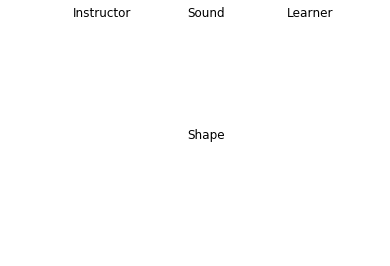

In [22]:
from SensorimotorExploration.Systems.Diva2017a import Diva2017a
from matplotlib import animation
import matplotlib.gridspec as gridspec
import subprocess as sp

instructor_file =  '../../Systems/datasets/german_dataset_3.h5'
instructor_data = load_sim_h5(instructor_file)
sys1 = Diva2017a()
sys2 = Diva2017a()

figVocalTract = plt.figure()
gs_vt = gridspec.GridSpec(2,5)

ax1 = plt.subplot(gs_vt[:,:2])
ax2 = plt.subplot(gs_vt[:,-2:])
ax3 = plt.subplot(gs_vt[0,2])
ax4 = plt.subplot(gs_vt[1,2])


instructor_line, = ax1.plot([], [], 'b',lw=1.5)
learner_line, = ax2.plot([], [], 'r',lw=1.5)
isound_line, = ax3.plot([], [], 'b',lw=1)
lsound_line, = ax3.plot([], [], 'r',lw=1)
ishape_line, = ax4.plot([], [], 'b',lw=1)
lshape_line, = ax4.plot([], [], 'r',lw=1)

lines = [instructor_line, learner_line, isound_line, lsound_line,
        ishape_line, lshape_line]




for ax_ in [ax1,ax2,ax3,ax4]:
    ax_.axis('off')
    ax_.axis('off')
    
for ax_ in [ax1,ax2]:
    ax_.set_xlim(-20,160)
    ax_.set_ylim(-200,100)
ax3.set_xlim(0,6000)
ax3.set_ylim(-2,2)
ax4.set_xlim(0,200)
ax4.set_ylim(-1,4.5)
ax1.invert_xaxis()
ax1.set_title("Instructor")
ax2.set_title("Learner")
ax4.set_title("Shape")
ax3.set_title("Sound")
    
def init():
    for line in lines:
        line.set_data([], [])
    lines[-4].set_data(range(len(sys1.soundWave)),sys1.soundWave + 1)
    lines[-3].set_data(range(len(sys2.soundWave)),sys2.soundWave - 1)
    return lines,

def data_gen(index):
    #print(index)
    d1=161
    d2=61
    d3=161
    dt = d1+d2+d3
    x3,x4,y3,y4 = [],[],[],[]
    if index < d1:
        x1 = np.real(sys1.vt_shape[index])
        x2 = np.real(sys2.vt_shape[0])
        y1 = np.imag(sys1.vt_shape[index]) 
        y2 = np.imag(sys2.vt_shape[0]) 
        x3 = range(len((sys1.af[index]))) 
        y3 = sys1.af[index]
    elif index < d1+d2:        
        x1 = np.real(sys1.vt_shape[-1])
        x2 = np.real(sys2.vt_shape[0])
        y1 = np.imag(sys1.vt_shape[-1]) 
        y2 = np.imag(sys2.vt_shape[0])
    elif index < dt:
        index2 = index - d1 - d2
        x1 = np.real(sys1.vt_shape[-1])
        x2 = np.real(sys2.vt_shape[index2])
        y1 = np.imag(sys1.vt_shape[-1]) 
        y2 = np.imag(sys2.vt_shape[index2]) 
        x3 = range(len((sys1.af[index2]))) 
        y3 = sys1.af[index2]
        x4 = range(len((sys2.af[index2]))) 
        y4 = sys2.af[index2]
    lines[0].set_data(x1,y1)
    lines[1].set_data(x2,y2)
    lines[-2].set_data(x3,y3)
    lines[-1].set_data(x4,y4)
    return lines,


x1_, x2_, y1_, y2_ = [], [], [], []
  

def get_video_interaction(sys1, sys2, show=0, file_name='vt', keep_audio=0):
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=1 / 0.005, metadata=dict(artist='Juan Manuel Acevedo Valle'))

    sys1.get_sound(save=1, file_name=file_name + '1')
    sys2.get_sound(save=1, file_name=file_name + '2')

    command = ["sox",
              file_name + '1.wav',
              'silence10ms.wav','silence20ms.wav',
              file_name + '2.wav',
              file_name +'.wav']  #Sometimes the audio causes problems to ffmpeg
    
    print(command)
    sp.call(command)

    
    sys1.get_vt_shape(sound=True)
    sys2.get_vt_shape(sound=True)

    im_ani = animation.FuncAnimation(figVocalTract, data_gen,
                                     init_func=init, 
                                     frames=161*2+61, blit=False,
                                     interval=1,  repeat=False)
    
    im_ani.save(file_name + '.mp4', writer=writer, codec="libx264")
    
    x = 60
    delay = 1.0
    timeout = int(x / delay)
    command = ["ffmpeg",
               '-i', file_name + '.wav',
               '-i', file_name + '.mp4',
               '-strict', '-2',
              '-c:v', "libx264", file_name + '_audio.mp4']
    
    task = sp.Popen(command)
    while task.poll() is None and timeout > 0:
        time.sleep(delay)
        timeout -= delay
    try:
        task.kill()
    except OSError:
        pass 
    task.wait()
    
    if keep_audio == 0:
        command = ["rm",
                   file_name + '.wav',
                   file_name + '1.wav',
                   file_name + '2.wav',
                   file_name + '.mp4']
        sp.call(command)
    if (show):
        figVocalTract.show()
    else:
        plt.close(figVocalTract)

In [31]:
directory = 'experiment_1/'
data_files = os.listdir(directory)

for data_file in (d_f for d_f in data_files if 'sim_data.h5' in d_f):        
    data_file = directory + data_file
    conf_file = data_file.replace('sim_data.h5', 'conf.txt')
    conf = {}

    with open(conf_file) as f:
        for line in f:
            line = line.replace('\n', '')
            (key, val) = line.split(': ')
            conf[key] = val

    if conf['mode']=='autonomous': #comment this two lines
        continue                       #to consider all the folders
    try:
            
        whole_data = load_sim_h5(data_file)
        interaction_data = whole_data.social.data.as_matrix(columns=None)
        interactions = np.zeros((interaction_data.shape[0],))
        interactions[~np.isnan(interaction_data[:, 0])] = 1

        social_data = load_sim_h5(data_file.replace('sim_data.h5', 'eva_valset.h5'))
        
        error_ = np.linalg.norm(social_data.sensor_goal.data.as_matrix() -
                                  social_data.sensor.data.as_matrix(), axis=1)
        
        
        best_idx = error_.argsort()[:100][::-1]

        
        try:
            exp_directory = data_file.replace('sim_data.h5', 
                                              conf['type'] + '_' + conf['mode'])
#             /home/yumilceh/Documents/exp_Epirob_coart
            exp_directory = '/home/yumilceh/Documents/exp_Epirob_coart/' + exp_directory
            os.mkdir(exp_directory)
            
        except OSError:
            print('WARNING. Directory already exists.')
            
        for i in best_idx:
            sys1.set_action(instructor_data.motor.data.iloc[i])

            sys2.set_action(social_data.motor.data.iloc[i])

            #get_video_interaction(sys1, sys2, file_name = exp_directory + '/sample' + str(i))
            #commeted to get only vocaliztion evolutions
        
        if conf['mode']=='autonomous':
            continue  
        n_evo = 5
        evo_found = False
        ii = 0
        while evo_found is False:
            best_sample = instructor_data.sensor.data.iloc[best_idx[ii]].as_matrix()
            data_tmp = whole_data.social.data.as_matrix()
            data_tmp = np.sum(data_tmp, axis=1)
            best_sample_idx = np.where(np.all([
                               [data_tmp+0.000000001>=sum(best_sample)],  
                               [data_tmp-0.000000001<=sum(best_sample)]],axis=0))[1]
            ii += 1
            if len(best_sample_idx)>5 \
                and   np.all(best_sample>0):
                evo_found = True
            
        
        
        step_idx = np.int(np.floor(len(best_sample_idx)/n_evo))
        i = 0
        while i < n_evo-1:
            sys1.set_action(instructor_data.motor.data.iloc[best_idx[0]])
            sys1.execute_action()

            sys2.set_action(whole_data.motor.data.iloc[best_sample_idx[i*step_idx]])
            sys2.execute_action()

            get_video_interaction(sys1, sys2, file_name = exp_directory + '/evo' + str(best_idx[0]) + '_' + str(i))
            i += 1
                                                       
                                            
            
        sys1.set_action(instructor_data.motor.data.iloc[best_idx[0]])
        sys1.execute_action()

        sys2.set_action(whole_data.motor.data.iloc[best_sample_idx[-1]])
        sys2.execute_action()

        get_video_interaction(sys1, sys2, file_name = exp_directory + '/evo' + str(best_idx[0]) + '_' + str(n_evo-1))

        

        
    except ValueError:
        print('ERROR')
        pass

['sox', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_5_2017_03_29_04_05_proprio_social/evo164_01.wav', 'silence10ms.wav', 'silence20ms.wav', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_5_2017_03_29_04_05_proprio_social/evo164_02.wav', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_5_2017_03_29_04_05_proprio_social/evo164_0.wav']
['sox', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_5_2017_03_29_04_05_proprio_social/evo164_11.wav', 'silence10ms.wav', 'silence20ms.wav', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_5_2017_03_29_04_05_proprio_social/evo164_12.wav', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_5_2017_03_29_04_05_proprio_social/evo164_1.wav']
['sox', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_5_2017_03_29_04_05_proprio_social/evo164_21.wav', 'silence10ms.wav', 'silence20ms.wav', '/home/yumilceh/Documents/exp_Epirob_c

['sox', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_5_2017_03_28_02_40_proprio_social/evo244_11.wav', 'silence10ms.wav', 'silence20ms.wav', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_5_2017_03_28_02_40_proprio_social/evo244_12.wav', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_5_2017_03_28_02_40_proprio_social/evo244_1.wav']
['sox', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_5_2017_03_28_02_40_proprio_social/evo244_21.wav', 'silence10ms.wav', 'silence20ms.wav', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_5_2017_03_28_02_40_proprio_social/evo244_22.wav', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_5_2017_03_28_02_40_proprio_social/evo244_2.wav']
['sox', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_5_2017_03_28_02_40_proprio_social/evo244_31.wav', 'silence10ms.wav', 'silence20ms.wav', '/home/yumilceh/Documents/exp_Epirob_c

['sox', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_7_2017_03_29_04_05_simple_social/evo164_21.wav', 'silence10ms.wav', 'silence20ms.wav', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_7_2017_03_29_04_05_simple_social/evo164_22.wav', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_7_2017_03_29_04_05_simple_social/evo164_2.wav']
['sox', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_7_2017_03_29_04_05_simple_social/evo164_31.wav', 'silence10ms.wav', 'silence20ms.wav', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_7_2017_03_29_04_05_simple_social/evo164_32.wav', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_7_2017_03_29_04_05_simple_social/evo164_3.wav']
['sox', '/home/yumilceh/Documents/exp_Epirob_coart/experiment_1/Vowels_Tree_7_2017_03_29_04_05_simple_social/evo164_41.wav', 'silence10ms.wav', 'silence20ms.wav', '/home/yumilceh/Documents/exp_Epirob_coart/ex

In [37]:
#Do not delete, is useful to debug
print(instructor_data.sensor.data.iloc[best_idx[0]].as_matrix())
print(whole_data.social.data.iloc[best_sample_idx].as_matrix())
print(whole_data.sensor_goal.data.iloc[best_sample_idx[0]].as_matrix())
print(sum(whole_data.sensor_goal.data.iloc[best_sample_idx[0]].as_matrix()))
print(whole_data.sensor_goal.data.iloc[best_sample_idx[1]].as_matrix())
print(sum(whole_data.sensor_goal.data.iloc[best_sample_idx[1]].as_matrix()))
print(instructor_data.sensor.data.iloc[best_idx[0]].as_matrix())
print(sum(instructor_data.sensor.data.iloc[best_idx[0]].as_matrix()))

[ 1.06400029  1.23933316  1.          0.62063852  1.09724882  1.        ]
[[ 0.53000022  1.45266647  1.          0.06877911  0.08486592  0.07894737]
 [ 0.53000022  1.45266647  1.          0.06877911  0.08486592  0.07894737]
 [ 0.53000022  1.45266647  1.          0.06877911  0.08486592  0.07894737]
 [ 0.53000022  1.45266647  1.          0.06877911  0.08486592  0.07894737]
 [ 0.53000022  1.45266647  1.          0.06877911  0.08486592  0.07894737]
 [ 0.53000022  1.45266647  1.          0.06877911  0.08486592  0.07894737]
 [ 0.53000022  1.45266647  1.          0.06877911  0.08486592  0.07894737]
 [ 0.53000022  1.45266647  1.          0.06877911  0.08486592  0.07894737]
 [ 0.53000022  1.45266647  1.          0.06877911  0.08486592  0.07894737]
 [ 0.53000022  1.45266647  1.          0.06877911  0.08486592  0.07894737]
 [ 0.53000022  1.45266647  1.          0.06877911  0.08486592  0.07894737]
 [ 0.53000022  1.45266647  1.          0.06877911  0.08486592  0.07894737]
 [ 0.53000022  1.45266647 

In [38]:
print(best_sample)

[ 0.53000022  1.45266647  1.          0.06877911  0.08486592  0.07894737]


## 